In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from typing import List, Callable

In [2]:
"""
    m - count of experience 
    n - count of features
"""


def h_Θ_x(Θ, x):
    return x.dot(Θ)


class Builder:
    __slots__ = ('x', 'y', 'm', 'n')
    
    @classmethod
    def from_dataframe(cls, df: pd.DataFrame):
        x: 'Matrix[m, n+1]' = df.iloc[:, 0:-1]
        x.insert(0, 'x0', 1)
        
        _, n = x.shape
        x.columns = range(n)
        
        y: 'Matrix[m, 1]' = pd.DataFrame(df.iloc[:, -1])
        y.columns = range(1)

        return cls(x=x, y=y)
    
    def __init__(self, x, y):
        assert len(x) == len(y)
        self.x = x
        self.y = y
        self.m, self.n = x.shape
        
    def build_J(self):
        def _J(Θ) -> 'Martix[m, 1]':
            return (((h_Θ_x(Θ, self.x) - self.y)**2).sum() / 2 / self.m).values[0]
        return _J

    def gradient_descent(self, 
                         α=1e-1, ϵ=1e-3, 
                         step_count=int(1e+3), slow_rate=1e-2,
                         α_up=lambda α: α*2, 
                         α_down=lambda α: α/2 ):
        J = self.build_J()
        
        Θ = pd.DataFrame(np.random.random(self.n))
        line = pd.DataFrame()
        α_history = np.zeros(step_count)
        
        for i in range(step_count):
            α_history[i] = α
            
            Δ = h_Θ_x(Θ, self.x) - self.y
            new_Θ = Θ - self.x.apply(lambda col: col.dot(Δ)).T * α / self.m
            
            J_Θ, J_new_Θ = J(Θ), J(new_Θ)
            ΔJ = J_Θ - J_new_Θ
            row = Θ.append(pd.Series(J_Θ), ignore_index=True)
            line = line.append(row.T)
            
            if ΔJ < 0:
                α = α_down(α)
                continue
            if ΔJ <= ϵ:
                break
            elif ΔJ < slow_rate:
                α = α_up(α)            
            Θ = new_Θ

        return Θ, line, α_history

In [3]:
def test_J():
    x = pd.DataFrame([[1, 3],[1, 7],[1, 4]])
    y = pd.DataFrame([10, 20, 7])
    Θ = pd.DataFrame([5, 3])
    
    builder = Builder(x=x, y=y)
    J = builder.build_J()
    assert J(Θ) == 152/2/3


test_J()

# PART 1

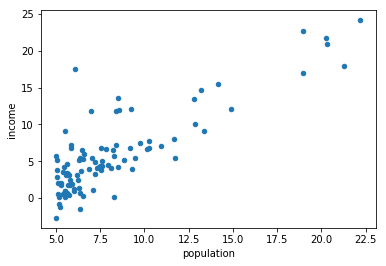

In [4]:
df1 = pd.read_csv('Data/Lab 1/ex1data1.txt', names=['population', 'income'])
builder = Builder.from_dataframe(df1)
J = builder.build_J()
df1.plot.scatter(x='population', y='income')

In [5]:
Θ_gd, gd_line, α_history = builder.gradient_descent(α_up=lambda α: α)

(431, 3)

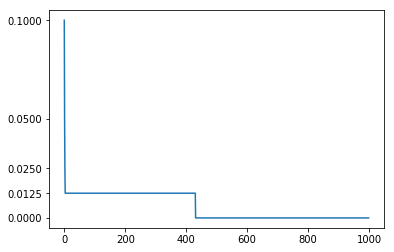

In [6]:
ax = plt.subplot()
ax.plot(range(len(α_history)), α_history)
ax.set_yticks(sorted(set(α_history)))
gd_line.shape

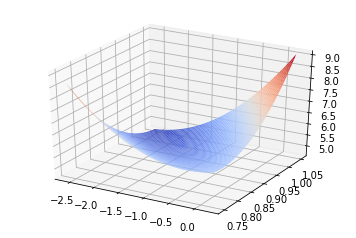

In [7]:
def Jfn(Θ0, Θ1):
    x = builder.x.to_numpy()
    y = builder.y.to_numpy()
    return sum([
        (Θ0*xi0 + Θ1*xi1 - y[i])**2
        for i, (xi0, xi1) in enumerate(x)]) / 2 / builder.m

Θ0, Θ1 = np.meshgrid(np.linspace(-2.6, 0.25), np.linspace(0.75, 1.05))
J_Θ0_Θ1 = Jfn(Θ0, Θ1)

# 3D Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
_ = ax.plot_surface(
    Θ0, Θ1, J_Θ0_Θ1, 
    cmap=plt.cm.coolwarm,linewidth=0)

In [8]:
Θ0

array([[-2.6       , -2.54183673, -2.48367347, ...,  0.13367347,
         0.19183673,  0.25      ],
       [-2.6       , -2.54183673, -2.48367347, ...,  0.13367347,
         0.19183673,  0.25      ],
       [-2.6       , -2.54183673, -2.48367347, ...,  0.13367347,
         0.19183673,  0.25      ],
       ...,
       [-2.6       , -2.54183673, -2.48367347, ...,  0.13367347,
         0.19183673,  0.25      ],
       [-2.6       , -2.54183673, -2.48367347, ...,  0.13367347,
         0.19183673,  0.25      ],
       [-2.6       , -2.54183673, -2.48367347, ...,  0.13367347,
         0.19183673,  0.25      ]])

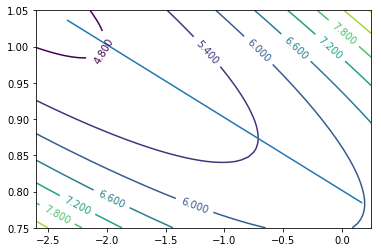

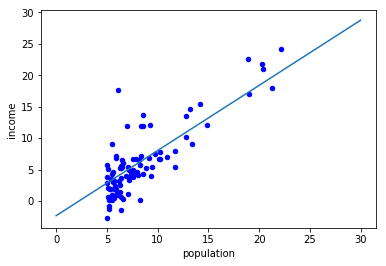

In [9]:
ax = plt.subplot()
ax.plot(gd_line[6:][0], gd_line[6:][1])
CS = ax.contour(Θ0, Θ1, J_Θ0_Θ1)
ax.clabel(CS, inline=1, fontsize=10)


ax = df1.plot.scatter(x='population', y='income', c='blue')
ax.plot(
    [0, 30],
    [Θ_gd.values[0], Θ_gd.values[0] + Θ_gd.values[1]*30]
)

# PART 2

In [10]:
# Read data
df2 = pd.read_csv('Data/Lab 1/ex1data2.txt', names=['square', 'room_count', 'cost'])
df2[:3]

square  room_count    cost
0    2104           3  399900
1    1600           3  329900
2    2400           3  369000

In [43]:
def h(θ, x):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        
        Returns
        -------
        h: array, shape (m, 1)
    """
    m = len(x)
    return x.dot(θ).reshape(m, 1)


def COST_F(θ, x, y):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        y: array, shape (m, 1)
        
        Returns
        -------
        cost: array, shape (m, 1)
    """
    m = len(x)
    cost = 0.5 * (h(θ, x) - y)**2
    return cost
    

def J_F(θ, x, y, λ):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        y: array, shape (m, 1)
        λ: number
        
        Returns
        -------
        J: number
    """
    cost = COST_F(θ, x, y)
    return cost.mean() + λ * (θ[1:]**2).sum()


def GD(θ, x, y, λ, α=1e-2, ϵ=1e-4, niter=int(1e5)):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        y: array, shape (m, 1)
        λ: number
        α: number
        ϵ: number
        
        Returns
        -------
        θ: array, shape (n, )
    """
    m, n = x.shape
    J_hist = []
    for i in range(niter):
        Δ = h(θ, x) - y
        
        θ_new = np.zeros(n, dtype=np.float64)
        θ_new[0] = θ[0] - α * (Δ*x[:, [0]]).mean()
        for j in range(1, n):
            θ_new[j] = θ[j]*(1-α*λ/m) - α*(Δ*x[:,[j]]).mean()
        
        J_θ = J_F(θ, x, y, λ)
        J_θ_new = J_F(θ_new, x, y, λ)
        ΔJ = J_θ - J_θ_new 

        J_hist.append(J_θ)
        
        if ΔJ < 0:
            α /= 2
            continue
        elif ΔJ < ϵ:
            break
        
        θ = θ_new
        
    return θ, J_hist

In [58]:
def h_unvector(θ, x):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        
        Returns
        -------
        h: array, shape (m, 1)
    """
    m, n = x.shape
    
    result = np.zeros((m, 1))
    for i in range(m):
        for j in range(n):
            result[i] += x[i,j] * θ[j]
    return result


def J_F_unvector(θ, x, y):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        y: array, shape (m, 1)
        λ: number
        
        Returns
        -------
        J: number
    """
    m, n = x.shape

    cost = 0
    h_values = h_unvector(θ, x)
    for i in range(m):
        cost += (h_values[i] - y[i])**2
    return (cost / 2 / m)[0]

In [34]:
X = df2[['square', 'room_count']].values
m, n = X.shape
y = df2[['cost']].values

Θ_init = np.random.random(n)
Θ, J_hist = GD(Θ_init, X, y, λ=1)

In [35]:
# Normalize
df_norm = df2.copy()
x = df_norm.iloc[:, :2]
x = (x - x.mean()) / (x.std())
df_norm.iloc[:, :2] = x
df_norm[:3]

square  room_count    cost
0  0.130010   -0.223675  399900
1 -0.504190   -0.223675  329900
2  0.502476   -0.223675  369000

In [36]:
X = df_norm[['square', 'room_count']].values
m, n = X.shape
y = df_norm[['cost']].values

Θ_norm, J_hist_norm = GD(Θ_init, X, y, λ=1)

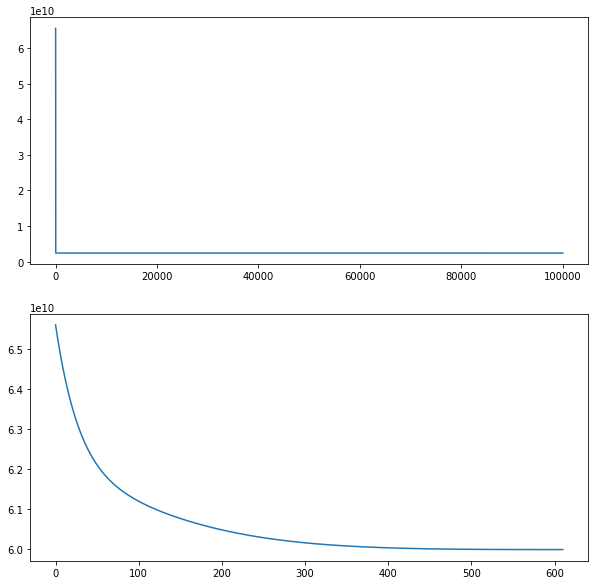

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(J_hist)
ax[1].plot(J_hist_norm)

In [59]:
X = df_norm[['square', 'room_count']].values
m, n = X.shape
y = df_norm[['cost']].values
Θ_init = np.random.random(n)

In [60]:
%%time
J_F(Θ_init, X, y, λ=0)

CPU times: user 108 µs, sys: 10 µs, total: 118 µs
Wall time: 112 µs


65591473491.9018

In [61]:
%%time
J_F_unvector(Θ_init, X, y)

CPU times: user 1.18 ms, sys: 253 µs, total: 1.43 ms
Wall time: 1.26 ms


65591473491.90182

In [41]:
# θ_analytic = pd.DataFrame(np.linalg.pinv((b2.x.T.dot(b2.x)).values)).dot(b2.x.T).dot(b2.y)